# Fasttext tweet classification

## Data file creation

In [1]:
import datetime
import os
import pandas as pd
import random
import re
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [2]:
DATADIR = "../data/"
TOPIC = "distance"
FILETWEETS = TOPIC+"-tweets.csv"
FILEANNOTATIONS = FILETWEETS+".human-labels.txt"
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
LARGEINT = 9999999999
LABEL = "label"
TEXT = "text"
USER = "user"
IDSTR = "id_str"
ANNOTATOR = "erikt@xs4all.nl"

In [3]:
tweets = pd.read_csv(DATADIR+FILETWEETS,index_col=IDSTR)
annotations = pd.read_csv(DATADIR+FILEANNOTATIONS,header=None,sep=" ")

In [4]:
fasttextData = {}
for i in range(0,len(annotations)):
    annotator = annotations.iloc[i][0]
    tweetId = annotations.iloc[i][2]
    tweetLabel = annotations.iloc[i][4]
    if annotator == ANNOTATOR and tweetId in list(tweets.index):
        tweetLabel = annotations.iloc[i][4]
        tweetUser = tweets.loc[tweetId][1]
        fasttextData[tweetId] = {LABEL:LABELPREFIX+tweetLabel,\
                                 USER:tweetUser,\
                                 TEXT:" ".join(TweetTokenizer().tokenize(tweets.loc[tweetId][TEXT]))}

In [5]:
outFile = open(FILEFASTTEXT,"w")
seenTexts = {}
for tweetId in fasttextData:
    if not fasttextData[tweetId][TEXT] in seenTexts:
        print(fasttextData[tweetId][LABEL],fasttextData[tweetId][TEXT],file=outFile)
        seenTexts[fasttextData[tweetId][TEXT]] = True
outFile.close()

In [161]:
nbrOfAnnotationMinutes = len(set([str(x)[:12] for x in annotations[1]]))
nbrOfAnnotatedTweets = len(set([str(x)[:12] for x in annotations[2]]))
print("tweets annotated per minute:",round(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes,1),"; 1000 tweets take:",round(1000/(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes)),"minutes")

tweets annotated per minute: 5.5 ; 1000 tweets take: 183 minutes


## Fasttext run and evaluation

In [6]:
import fasttext
import random
from IPython.display import clear_output

In [7]:
PRETRAINEDDIR = "/home/erikt/projects/newsgac/fasttext-runs/"
WIKIFILENAME = "wiki.nl.vec"

In [8]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [9]:
fasttextData = []
inFile = open(FILEFASTTEXT,"r")
for line in inFile: fasttextData.append(line.strip())
inFile.close()

In [10]:
DIM = 300
EPOCH = 100
LR = 0.1
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))

In [112]:
def runFasttext(fasttextData,dim=DIM,epoch=EPOCH,lr=LR,n=N,squealFlag=True):
    predictionCounts = []
    predictionLabels = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart = round(fold*len(fasttextData)/n)
        testEnd = round((fold+1)*len(fasttextData)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        testData = []
        for i in range(0,len(fasttextData)):
            data = fasttextData[i]
            if i < testStart or i >= testEnd: 
                print(data,file=trainFile)
            else: 
                print(data,file=testFile)
                testData.append(data)
        testFile.close()
        trainFile.close()
        model = fasttext.train_supervised(TRAIN,dim=dim,epoch=epoch,lr=lr)
        predictionCounts.append([*model.test(TEST)])
        predictionLabels.append(model.predict(testData))
        os.unlink(TRAIN)
        os.unlink(TEST)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCounts,predictionLabels)

In [118]:
def evaluate(predictionCounts):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    print("cases: {0}; precision: {1}; recall: {2}".format(caseTotal,precision,recall))
    return(precision)

In [120]:
scores = {}
for dim in [10,20,50,100,200,300]:
    for epoch in [10,20,50,100,200,300]:
        for lr in [0.05,0.1,0.2]:
            predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
            print(dim,epoch,lr,end=" ")
            key = " ".join([str(dim),str(epoch),str(lr)])
            scores[key] = evaluate(predictionCounts)

10 10 0.05 cases: 936; precision: 0.682; recall: 0.682
10 10 0.1 cases: 936; precision: 0.689; recall: 0.689
10 10 0.2 cases: 936; precision: 0.717; recall: 0.717
10 20 0.05 cases: 936; precision: 0.689; recall: 0.689
10 20 0.1 cases: 936; precision: 0.721; recall: 0.721
10 20 0.2 cases: 936; precision: 0.745; recall: 0.745
10 50 0.05 cases: 936; precision: 0.738; recall: 0.738
10 50 0.1 cases: 936; precision: 0.743; recall: 0.743
10 50 0.2 cases: 936; precision: 0.737; recall: 0.737
10 100 0.05 cases: 936; precision: 0.743; recall: 0.743
10 100 0.1 cases: 936; precision: 0.736; recall: 0.736
10 100 0.2 cases: 936; precision: 0.735; recall: 0.735
10 200 0.05 cases: 936; precision: 0.737; recall: 0.737
10 200 0.1 cases: 936; precision: 0.734; recall: 0.734
10 200 0.2 cases: 936; precision: 0.737; recall: 0.737
10 300 0.05 cases: 936; precision: 0.736; recall: 0.736
10 300 0.1 cases: 936; precision: 0.731; recall: 0.731
10 300 0.2 cases: 936; precision: 0.737; recall: 0.737
20 10 0.05 ca

In [122]:
[(scores[k],k) for k in sorted(scores.keys(),key=lambda k:scores[k],reverse=True)][0:10]

[(0.749, '100 100 0.05'),
 (0.749, '200 100 0.05'),
 (0.748, '50 20 0.2'),
 (0.747, '20 100 0.05'),
 (0.747, '50 50 0.1'),
 (0.747, '50 100 0.05'),
 (0.747, '300 100 0.05'),
 (0.746, '100 50 0.1'),
 (0.746, '200 20 0.2'),
 (0.746, '200 50 0.1')]

In [133]:
BESTDIM = 100
BESTEPOCH = 100
BESTLR = 0.05

predictionCounts,predictionLabels = runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR)

finished


In [134]:
evaluate(predictionCounts)

cases: 936; precision: 0.748; recall: 0.748


0.748

In [135]:
labelCountsGold = {}
for i in range(0,len(fasttextData)):
    label = fasttextData[i].split()[0]
    if label in labelCountsGold: labelCountsGold[label] += 1
    else: labelCountsGold[label] = 1
labelCountsGold

{'__label__REJECTS': 104, '__label__SUPPORTS': 638, '__label__IRRELEVANT': 194}

In [136]:
print("baseline accuracy:",round(max(labelCountsGold.values())/sum(labelCountsGold.values()),3))

baseline accuracy: 0.682


In [137]:
labelCountsPredicted = {}
for i in range(0,len(predictionLabels)):
    for label in predictionLabels[i][0]:
        if label[0] in labelCountsPredicted: labelCountsPredicted[label[0]] += 1
        else: labelCountsPredicted[label[0]] = 1
labelCountsPredicted

{'__label__IRRELEVANT': 148, '__label__REJECTS': 61, '__label__SUPPORTS': 727}

In [138]:
print("total absolute deviation",sum([abs(labelCountsPredicted[l]-labelCountsGold[l]) for l in labelCountsGold]))

total absolute deviation 178


In [139]:
print("relative deviation per label:",\
      {l:round(abs(labelCountsPredicted[l]-labelCountsGold[l])/labelCountsGold[l],3) for l in labelCountsGold})

relative deviation per label: {'__label__REJECTS': 0.413, '__label__SUPPORTS': 0.139, '__label__IRRELEVANT': 0.237}


In [140]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

makeConfusionMatrix(fasttextData,predictionLabels)

col_0,__label__IRRELEVANT,__label__REJECTS,__label__SUPPORTS
row_0,,,
__label__IRRELEVANT,84,21,89
__label__REJECTS,28,27,49
__label__SUPPORTS,36,13,589


For the mondkapje data, fasttext predicts 63% of the labels correctly without external dictionary and 66% with a Wikipedia dictionary (baseline: 46%). It overestimates the presence of negative labels and underestimates the level of positive and neutral labels. The amount of irrelevant labels is about right

In [141]:
multiplicationFactors = {}
for label in labelCountsGold:
    multiplicationFactors[label] = labelCountsGold[label]/labelCountsPredicted[label]
multiplicationFactors

{'__label__REJECTS': 1.7049180327868851,
 '__label__SUPPORTS': 0.8775790921595599,
 '__label__IRRELEVANT': 1.3108108108108107}

The multiplication factor for the positive label is unrealistically high so we will not use these factors.

In [142]:
predictedNumberOfLabels = 0
for label in labelCountsGold:
    predictedNumberOfLabels += multiplicationFactors[label]*labelCountsPredicted[label]
print(predictedNumberOfLabels,sum(labelCountsGold.values()))

936.0 936


## Classifying tweets

In [143]:
import fasttext
import matplotlib
import os
import pandas as pd
import re

In [144]:
DATADIRECTORY = "/home/erikt/projects/puregome/data/text/"
LABELPREFIX = "__label__"
NEGATIVE = LABELPREFIX+"NEGATIVE"
POSITIVE = LABELPREFIX+"POSITIVE"
NEUTRAL = LABELPREFIX+"NEUTRAL"
IRRELEVANT = LABELPREFIX+"IRRELEVANT"
SUPPORTS = LABELPREFIX+"SUPPORTS"
REJECTS = LABELPREFIX+"REJECTS"
SUPPORT = ""
TEXT = "text"
USER = "user"
DIM = BESTDIM
EPOCH = BESTEPOCH
LR = BESTLR

In [145]:
def makeGrepCommandFromQuery(query):
    grepCommand = "grep"
    for orPart in query.split("|"):
        grepCommand += ' -e "'+orPart+'"'
    return(grepCommand)

def readData(datePattern,query):
    fileList = sorted(os.listdir(DATADIRECTORY))
    tmpFileName = "classify."+str(int(random.random()*LARGEINT))+".txt"
    testData = []
    for inFileName in fileList:
        if re.search(datePattern,inFileName):
            os.system("gunzip -c "+DATADIRECTORY+inFileName+"| head -1 >"+tmpFileName)
            os.system("gunzip -c "+DATADIRECTORY+inFileName+"| "+makeGrepCommandFromQuery(query)+" >> "+tmpFileName)
            try: df = pd.read_csv(tmpFileName)
            except: continue
            for i in range(0,len(df)):
                if re.search(query,df.iloc[i][TEXT],flags=re.IGNORECASE):
                    testData.append(df.iloc[i][USER]+" "+df.iloc[i][TEXT])
            os.unlink(tmpFileName)
    return(testData)
    
def classify(datePattern,query):
    testData = readData(datePattern,query)
    model = fasttext.train_supervised(FILEFASTTEXT,dim=DIM,epoch=EPOCH,lr=LR)
    predictedLabels = model.predict(testData)
    predictedGroups = pd.DataFrame(predictedLabels[0]).groupby(0).groups
    labelCountsPredicted = {label:len(predictedGroups[label]) for label in predictedGroups}
    nbrOfLabels = sum([labelCountsPredicted[label] for label in labelCountsPredicted if label != IRRELEVANT])
    labelPercentages = { label:round(100*labelCountsPredicted[label]/nbrOfLabels,1) for label in labelCountsPredicted}
    return(labelPercentages)

In [146]:
QUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
MAXDAYSPERMONTH = 31

results = {}
for month in "202002 202003 202004 202005 202006 202007".split():
    for day in range(1,MAXDAYSPERMONTH+1):
        date = month+str(day).zfill(2)
        try:
            labels = classify(date,QUERY)
            if not REJECTS in labels: labels[REJECTS] = 0
            if not SUPPORTS in labels: labels[SUPPORTS] = 0
            if not IRRELEVANT in labels: labels[IRRELEVANT] = 0
            if labels[REJECTS]+labels[SUPPORTS]+labels[IRRELEVANT] > 0:
                results[date] = labels
            print(date,labels[REJECTS],labels[SUPPORTS],labels[IRRELEVANT])
        except:
            print(date,"error")

20200201 3.4 96.6 159.3
20200202 5.4 94.6 210.7
20200203 1.5 98.5 127.7
20200204 5.2 94.8 234.5
20200205 1.7 98.3 119.0
20200206 1.8 98.2 129.1
20200207 7.6 92.4 143.9
20200208 8.2 91.8 155.7
20200209 10.3 89.7 174.4
20200210 9.2 90.8 141.5
20200211 4.4 95.6 377.9
20200212 4.8 95.2 176.2
20200213 4.5 95.5 140.9
20200214 8.9 91.1 216.1
20200215 9.1 90.9 194.5
20200216 1.5 98.5 126.9
20200217 5.5 94.5 203.6
20200218 10.5 89.5 115.8
20200219 1.1 98.9 98.9
20200220 3.2 96.8 573.0
20200221 4.7 95.3 145.3
20200222 11.3 88.7 148.4
20200223 3.1 96.9 121.9
20200224 3.6 96.4 209.6
20200225 22.1 77.9 186.8
20200226 1.5 98.5 86.9
20200227 1.4 98.6 108.6
20200228 3.8 96.2 113.3
20200229 14.7 85.3 170.6
20200230 error
20200231 error
20200301 5.7 94.3 81.3
20200302 5.4 94.6 75.9
20200303 6.2 93.8 74.0
20200304 2.4 97.6 132.9
20200305 3.8 96.2 234.6
20200306 3.4 96.6 98.9
20200307 3.1 96.9 130.9
20200308 2.2 97.8 68.8
20200309 4.7 95.3 47.4
20200310 0.6 99.4 53.2
20200311 2.4 97.6 54.2
20200312 1.3 98

In [147]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

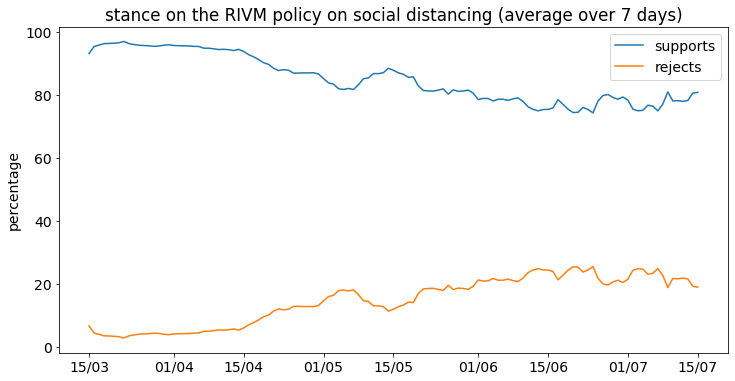

In [149]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

DATEFORMAT = "%Y%m%d"
DAYSCOMBINED = 7
STARTDATE = "20200315"
PEAKID = 101

results = {k:results[k] for k in sorted(results.keys())}
font = {"size":14}
matplotlib.rc("font",**font)
fig,ax = plt.subplots(figsize=(12,6))
x = [datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys() if k >= STARTDATE ]
y = movingAverage([results[k][SUPPORTS] for k in results.keys() if k >= STARTDATE],DAYSCOMBINED)
plt.plot_date(x,y,fmt="-",label="supports")
x = [datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys() if k >= STARTDATE]
y = movingAverage([results[k][REJECTS] for k in results.keys() if k >= STARTDATE],DAYSCOMBINED)
plt.plot_date(x,y,fmt="-",label="rejects")
plt.legend()
plt.title("stance on the RIVM policy on "+"social distancing"+" (average over "+str(DAYSCOMBINED)+" days)")
plt.ylabel("percentage")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
plt.show()